Importo los archivos los archivos y tomo las caracteristicas de interes



In [1]:
!pip install arch
!pip install statsmodel

  Obtaining dependency information for arch from https://files.pythonhosted.org/packages/13/40/26a9649a89e272b7f6b1beec4e13cd8b33575706dce3122698934c0a7e03/arch-6.1.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for pandas>=1.1 from https://files.pythonhosted.org/packages/b7/f8/32d6b5aa4c4bc045fa2c4c58f88c325facc54721956c6313f0afea8ea853/pandas-2.1.0-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/9.2 MB ? eta -:--:--
     ---------------------------------------- 0.0/9.2 MB 1.4 MB/s eta 0:00:07
     ---------------------------------------- 0.0/9.2 MB 1.4 MB/s eta 0:00:07
     ---------------------------------------- 0.0/9.2 MB 1.4 MB/s eta 0:00:07
     ---------------------------------------- 0.0/9.2 MB 1.4 MB/s eta 0:00:07
      --------------------------------------- 0.1/9.2 MB 516.7 kB/s eta 0:00:18
     - -------------------------------------- 0.3/9.2 MB 927.4 kB/s eta 0:00:10
     - -------------------------------------

ERROR: Could not find a version that satisfies the requirement statsmodel (from versions: none)
ERROR: No matching distribution found for statsmodel


In [61]:
import matplotlib.pyplot as plt
import h5py
import numpy as np
from arch.unitroot import ADF, PhillipsPerron
from statsmodels.tsa.stattools import adfuller, kpss
from scipy.interpolate import interp1d
from scipy.signal import butter, lfilter
import scipy

In [4]:
# Open hdf5 files
filename_h1 = 'h1_4khz_32s.hdf5'
filename_l1 = 'l1_4khz_32s.hdf5'

with h5py.File(filename_h1, 'r') as f_h1:
    h1_s = f_h1['strain/Strain'][...]
    h1_fs = 1 / f_h1['strain/Strain'].attrs['Xspacing']
    h1_st = f_h1['meta/GPSstart'][()]

with h5py.File(filename_l1, 'r') as f_l1:
    l1_s = f_l1['strain/Strain'][...]
    l1_fs = 1 / f_l1['strain/Strain'].attrs['Xspacing']
    l1_st = f_l1['meta/GPSstart'][()]

Realizo un EDA

In [7]:
gw_time = 1126259462.442
gw_st = gw_time - h1_st
gw_large = 0.2
time = np.arange(0,h1_s.shape[0]/h1_fs, 1/h1_fs)

In [8]:
gw_st

15.441999912261963

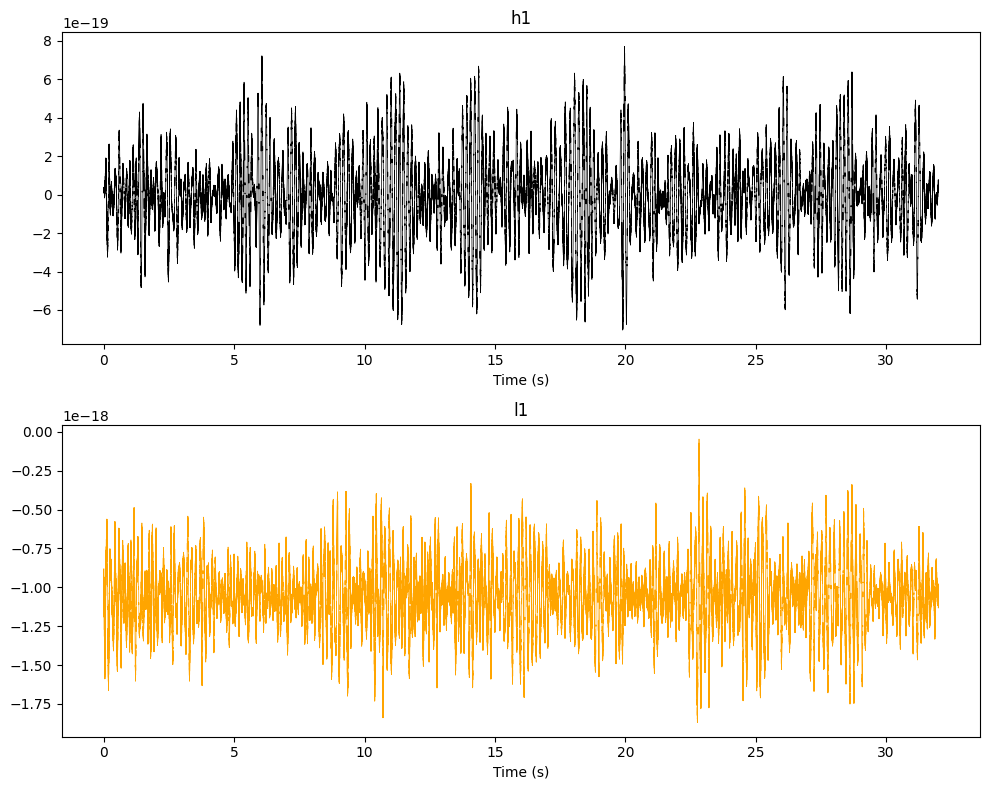

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax1.plot(time, h1_s, linewidth=0.5, color= "black")
ax1.set_title('h1')
ax1.set_xlabel('Time (s)')

ax2.plot(time, l1_s, linewidth=0.5, color= "orange")
ax2.set_title('l1')
ax2.set_xlabel('Time (s)')

plt.tight_layout()
plt.show()

Separo una porcion del espectro con el evento y analizo despues el ruido por separado

In [12]:
N = 1

#seccion con evento +-1s
h1_gw = h1_s[(time >= gw_st-N) & (time <= gw_st + N)]
l1_gw = l1_s[(time >= gw_st-N) & (time <= gw_st + N)]
time_gw = time[(time >= gw_st-N) & (time <= gw_st + N)]

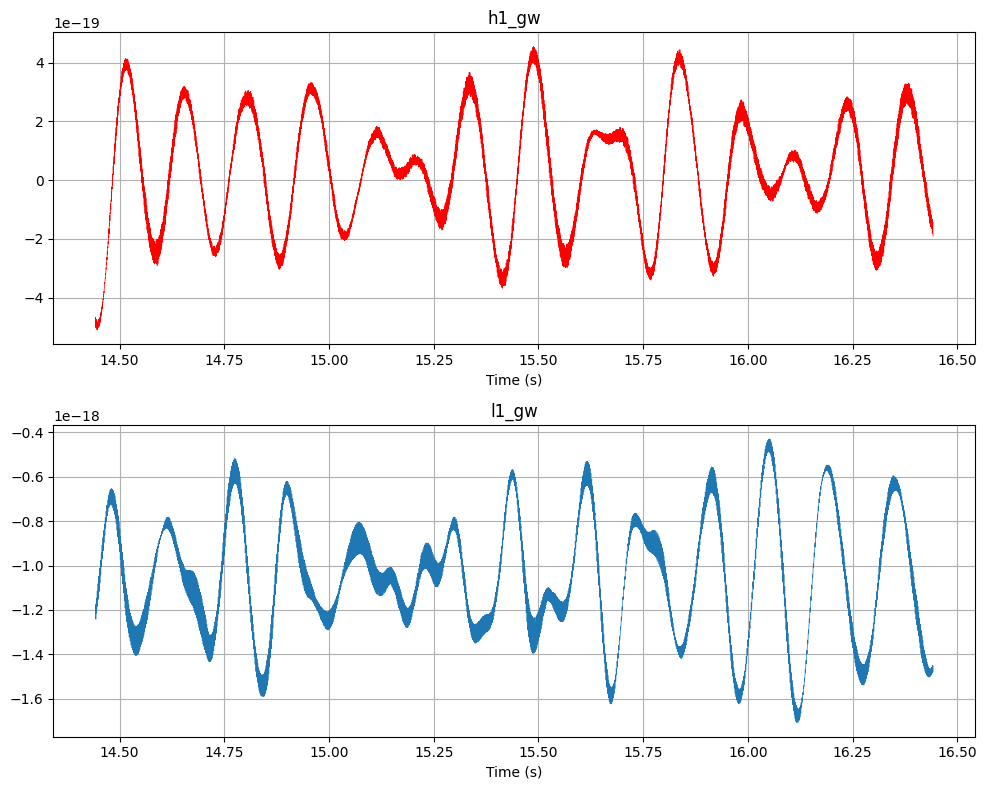

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax1.plot(time_gw, h1_gw, linewidth=0.5, color= "red")
ax1.grid()
ax1.set_title('h1_gw')
ax1.set_xlabel('Time (s)')
ax2.plot(time_gw, l1_gw, linewidth=0.5)
ax2.set_title('l1_gw')
ax2.set_xlabel('Time (s)')

plt.tight_layout()
ax2.grid()
plt.show()

Ahora separo el ruido para estudiar estacionareidad

In [23]:
#ruido cola derecha

h1_ruido = h1_s[(time > gw_st + N)]
l1_ruido = l1_s[(time > gw_st + N)]
time_ruido = time[(time > gw_st + N)]

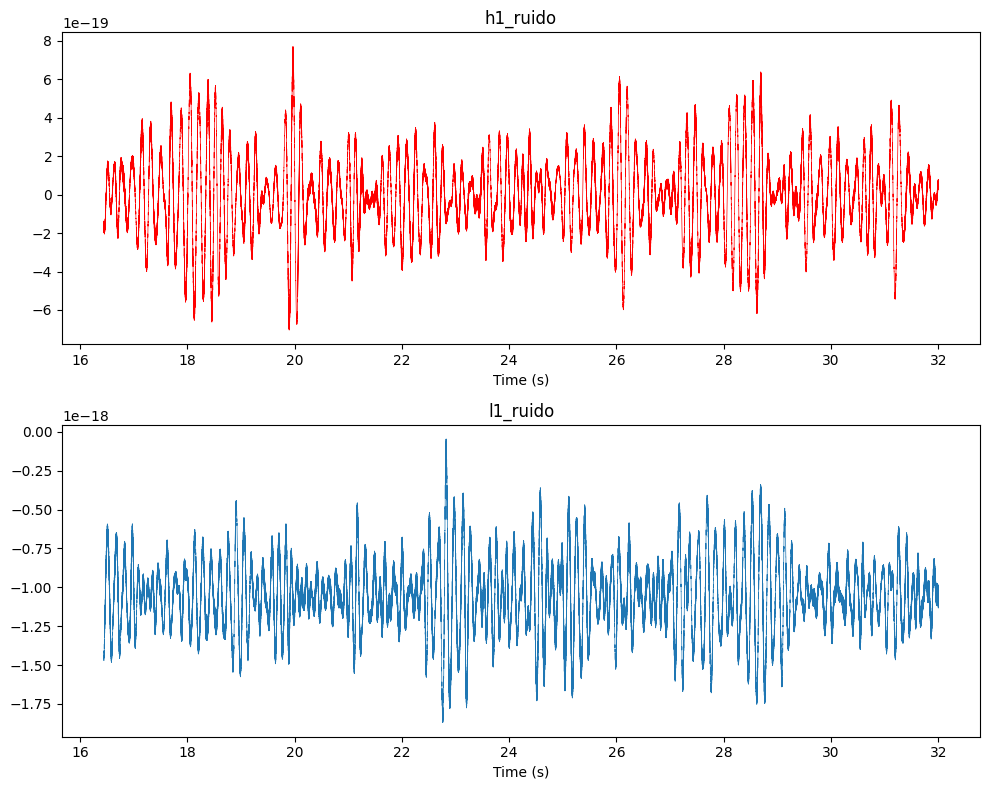

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax1.plot(time_ruido, h1_ruido, linewidth=0.5, color= "red")
ax1.set_title('h1_ruido')
ax1.set_xlabel('Time (s)')

ax2.plot(time_ruido, l1_ruido, linewidth=0.5)
ax2.set_title('l1_ruido')
ax2.set_xlabel('Time (s)')

plt.tight_layout()
plt.show()

TEST DE ESTACIONAREIDAD

Se multiplica por una constante grande, ya que debido a los valores de la señal hace underflow en algunos casos dando resultados erroneos

In [29]:
def EsEstacionario(signal, alpha):
  #PhillipsPerron Test
  phpr_result = PhillipsPerron(signal)
  phpr_p_value = phpr_result.pvalue
  phpr_test_result = "Stationary" if phpr_p_value < alpha else "Not stationary"
  print("Augmented Dickey-Fuller Test:", phpr_test_result)
  # Augmented Dickey-Fuller Test
  adf_result = ADF(signal)
  adf_p_value = adf_result.pvalue #adf_result[1]
  adf_test_result = "Stationary" if adf_p_value < alpha else "Not stationary"
  print("Augmented Dickey-Fuller Test:", adf_test_result)
  # Kwiatkowski-Phillips-Schmidt-Shin Test
  kpss_result = kpss(signal)
  kpss_p_value = kpss_result[1]
  kpss_test_result = "Stationary" if kpss_p_value > alpha else "Not stationary"
  print("Kwiatkowski-Phillips-Schmidt-Shin Test:", kpss_test_result)

In [37]:
#Valor significativo: 
alpha = 0.05

#95% de confianza

import warnings
warnings.filterwarnings('default')
warnings.simplefilter('default')

In [56]:
EsEstacionario(l1_ruido/np.max(abs(l1_ruido)), alpha)

c:\Users\joaco\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\unitroot\unitroot.py:1125: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma = resols.bse[0]
c:\Users\joaco\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\unitroot\unitroot.py:1133: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rho = resols.params[0]


Augmented Dickey-Fuller Test: Stationary
Augmented Dickey-Fuller Test: Stationary
Kwiatkowski-Phillips-Schmidt-Shin Test: Stationary


c:\Users\joaco\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\unitroot\unitroot.py:776: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self._stat = stat = resols.tvalues[0]
C:\Users\joaco\AppData\Local\Temp\ipykernel_4448\511359593.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(signal)


In [55]:
EsEstacionario(h1_ruido/np.max(abs(h1_ruido)), alpha)

c:\Users\joaco\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\unitroot\unitroot.py:1125: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma = resols.bse[0]
c:\Users\joaco\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\unitroot\unitroot.py:1133: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rho = resols.params[0]


Augmented Dickey-Fuller Test: Stationary
Augmented Dickey-Fuller Test: Stationary
Kwiatkowski-Phillips-Schmidt-Shin Test: Stationary


c:\Users\joaco\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\unitroot\unitroot.py:776: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self._stat = stat = resols.tvalues[0]
C:\Users\joaco\AppData\Local\Temp\ipykernel_4448\511359593.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(signal)


Da estacionario, restamos entonces las medias a cada señal.

In [57]:
h1_ruido = h1_ruido - np.mean(h1_ruido)
l1_ruido = l1_ruido - np.mean(l1_ruido)

Periodograma

In [71]:
def periodogram(x, win):
    N = len(x)
    w = scipy.signal.get_window(Nx = N, window = win)
    Rx = (scipy.fft.fft(x*w))**2 * (1/N)
    return Rx

c:\Users\joaco\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


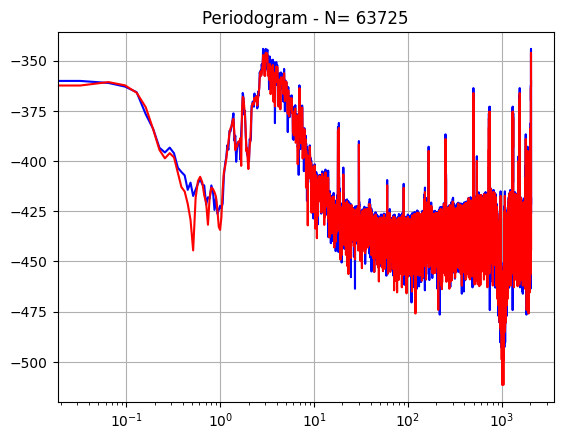

In [72]:
Rx = periodogram(h1_ruido, 'bartlett')
Rx2 = periodogram(h1_ruido, 'parzen')
x_ax = np.linspace(0,0.5, len(Rx)) * h1_fs
plt.plot(x_ax, 10*np.log10(Rx), 'blue')
plt.plot(x_ax, 10*np.log10(Rx2), 'red')
plt.title('Periodogram - N= ' + str(len(h1_ruido)))
plt.grid()
plt.xscale("log")
plt.show()

Welch Bartlett

In [132]:
def manualautocorr(x, L):
    #L es el lag máximo que quiero computar
    N = len(x)
    rx = np.zeros(N)
    for l in range(L):
        sum = 0
        for i in range(N-l):
            sum += (x[i]*x[i+l])/N
        rx[l]=sum
    rx2 = (rx[1:])[::-1]
    return np.concatenate([rx2, rx])


def autocorr(x):
    return scipy.signal.correlate(x,x, 'full')/len(x)


def apply_window(rx, L, win):
    N = len(rx)
    window = scipy.signal.get_window(Nx = 2*L+1, window = win)
    pw = int((N-len(window))/2)

    padded_window = np.pad(array = window, pad_width=pw)
    return rx*padded_window


def blackman_tuckey(signal, L, w):
    rx = autocorr(signal)
    N = len(signal)
    Rx_smoothing = abs(scipy.fft.fft(apply_window(rx, L, w)))
    return Rx_smoothing[:len(signal)]

In [75]:
def welch_bartlett(signal, w, segment_size, overlap = 0):

    X_prom = np.zeros(segment_size)
    N = len(signal)
    i=0
    segment_count = 0
    d = int(segment_size*(1-overlap))
    while i+segment_size<N:
        segment = signal[i:i+segment_size]
        s_len = len(segment)
        Xr = abs(scipy.fft.fft(segment*scipy.signal.get_window(Nx = s_len, window = w)))
        X_prom += np.power(Xr, 2)
        i=i+d
        segment_count+=1


    X_prom /= (segment_count*segment_size)

    return X_prom[:int(segment_size/2)]

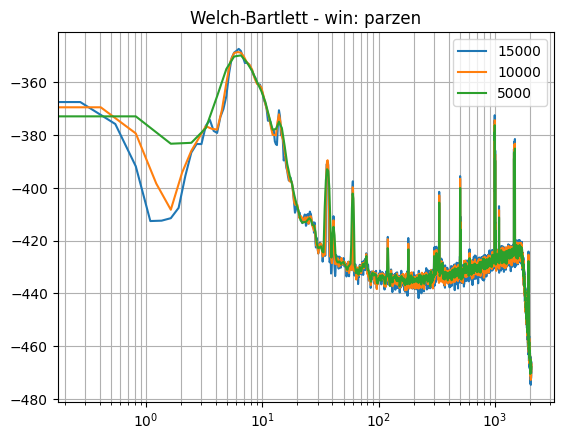

In [86]:
w = 'parzen'
L = 15000
Rx_pa = welch_bartlett(h1_ruido, w, L, overlap=0.5)
x_ax = np.linspace(0,0.5, len(Rx_pa)) * h1_fs
plt.plot(x_ax, 10*np.log10(Rx_pa), label = L)
plt.title('Welch-Bartlett - win: ' + w)


w = 'parzen'
L = 10000
Rx_pa = welch_bartlett(h1_ruido, w, L, overlap=0.5)
x_ax = np.linspace(0,0.5, len(Rx_pa)) * h1_fs
plt.plot(x_ax, 10*np.log10(Rx_pa), label = L)


w = 'parzen'
L = 5000
Rx_pa = welch_bartlett(h1_ruido, w, L, overlap=0.5)
x_ax = np.linspace(0,0.5, len(Rx_pa)) * h1_fs

plt.plot(x_ax, 10*np.log10(Rx_pa), label = L)

plt.xscale("log")
plt.grid(True, which="both")
plt.legend()
plt.show()

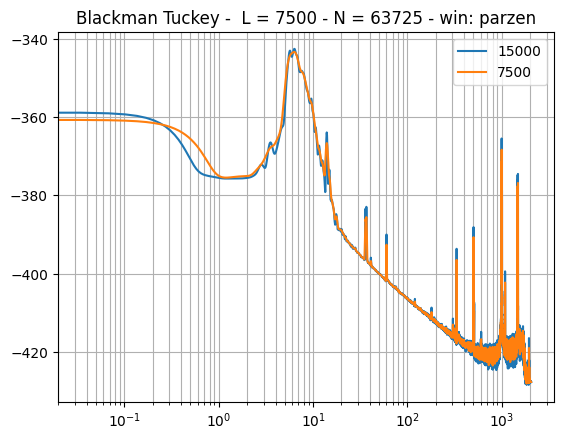

In [139]:
w = 'parzen'

N = 60000
L = int(N/4)

smoothRx = blackman_tuckey(h1_ruido[:N], L, w)
x_ax = np.linspace(0,0.5, len(smoothRx)) * h1_fs
plt.plot(x_ax, 10*np.log10(smoothRx), label = str(L))


N = 60000
L = int(N/8)

w = 'parzen'
smoothRx = blackman_tuckey(h1_ruido[:N], L, w)
x_ax = np.linspace(0,0.5, len(smoothRx)) * h1_fs

plt.plot(x_ax, 10*np.log10(smoothRx), label = str(L))
plt.title('Blackman Tuckey -  L = ' + str(L) + ' - N = ' + str(len(h1_ruido)) + ' - win: ' + w)
plt.grid(True, which='both')
plt.xscale("log")
plt.legend()

plt.show()

In [ ]:
w = 'parzen'
L = 15000
Rx_pa = welch_bartlett(h1_ruido, w, L, overlap=0.25)
plt.plot(np.array(range(len(Rx_pa)))/len(Rx_pa),20*np.log10(Rx_pa), label = L)
plt.title('Welch-Bartlett - win: ' + w)
#plt.grid()
#plt.xscale("log")

w = 'parzen'
L = 5000
Rx_pa = welch_bartlett(h1_ruido, w, L, overlap=0.25)
plt.plot(np.array(range(len(Rx_pa)))/len(Rx_pa),20*np.log10(Rx_pa), label = L)
#plt.title('Welch-Bartlett - win: ' + w)
#plt.grid()
#plt.xscale("log")

w = 'parzen'
L = 2000
Rx_pa = welch_bartlett(h1_ruido, w, L, overlap=0.25)
plt.plot(np.array(range(len(Rx_pa)))/len(Rx_pa), 20*np.log10(Rx_pa), label = L)
#plt.title('Welch-Bartlett - win: ' + w)
plt.grid()
plt.xscale("log")
plt.legend()
plt.show()

whitenning

hay que tomar el mejor metodo, y definir h1p_f a la frecuencia y h1p_p al espectro

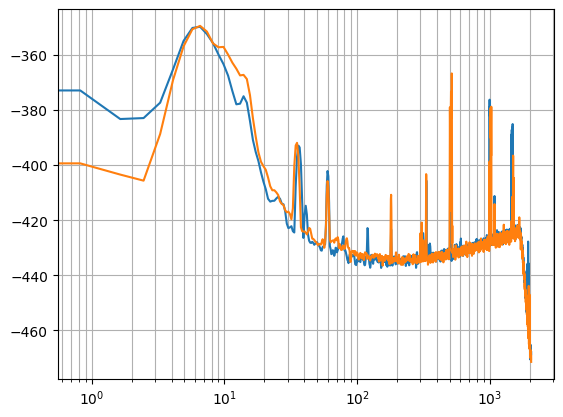

In [100]:
w = 'parzen'
L = 5000
h1p_p =  welch_bartlett(h1_ruido, w, L, overlap=0.5)
h1p_f = np.linspace(0,0.5, len(Rx_whitenning_h1)) * h1_fs
plt.plot(x_ax, 10*np.log10(Rx_whitenning_h1), label = str(L))


w = 'parzen'
L = 5000
l1p_p =  welch_bartlett(l1_ruido, w, L, overlap=0.5)
l1p_f = np.linspace(0,0.5, len(Rx_whitenning_l1)) * h1_fs
plt.plot(x_ax, 10*np.log10(Rx_whitenning_l1), label = str(L))

plt.xscale("log")
plt.grid(True, which="both")

In [101]:
h1_psd = interp1d(h1p_f, h1p_p, kind='nearest', bounds_error=False, assume_sorted=True)
l1_psd = interp1d(l1p_f, l1p_p, kind='nearest', bounds_error=False, assume_sorted=True)

In [102]:

h1_psd = np.abs(h1_psd(np.fft.rfftfreq(len(h1_s), 1/h1_fs)))**2
l1_psd = np.abs(l1_psd(np.fft.rfftfreq(len(l1_s), 1/l1_fs)))**2

# Signal whitening
h1_w = np.fft.irfft(np.fft.rfft(h1_s) / np.sqrt(h1_psd))
l1_w = np.fft.irfft(np.fft.rfft(l1_s) / np.sqrt(l1_psd))

In [103]:
nyqh = 0.5 * h1_fs
low_h = 30
high_h = 300
lowh = low_h / nyqh
highh = high_h / nyqh
bh, ah = butter(6, [lowh, highh], btype='band')

nyql = 0.5 * l1_fs
low_l = 20
high_l = 300
lowl = low_l / nyql
highl = high_l / nyql
bl, al = butter(6, [lowl, highl], btype='band')

# Apply passband filter
h1_f_w = lfilter(bh, ah, h1_w)
l1_f_w = lfilter(bl, al, l1_w)

In [127]:
import scipy.io.wavfile
wav_interval = (time > gw_st - 2) & (time < gw_st + 2)
#Scale signal to fit WAV format
h1_gw_fin = np.int16(h1_f_w[wav_interval]/np.max(np.abs(h1_f_w[wav_interval])) * 32767 * 0.9)
l1_gw_fin = np.int16(l1_f_w[wav_interval]/np.max(np.abs(l1_f_w[wav_interval])) * 32767 * 0.9)
scipy.io.wavfile.write('h1_gw.wav', int(h1_fs), h1_gw_fin)
scipy.io.wavfile.write('l1_gw.wav', int(l1_fs), l1_gw_fin)

In [130]:
from IPython.display import Audio
from pydub import AudioSegment

# Laden Sie die WAV-Datei
audio = AudioSegment.from_file("h1_gw.wav", format="wav")

# Definieren Sie die Anzahl der Halbtonschritte, um die Tonhöhe zu ändern
upshift = 4 # Zum Beispiel um 2 Halbtöne erhöhen

# Ändern Sie die Tonhöhe der Audiodatei
shifted_audio = audio.speedup(playback_speed=(2**(upshift/12.0)))

# Speichern Sie die veränderte Audiodatei
shifted_audio.export("h1_gw_upshifted.wav", format="wav")

# Load an audio file
audio_file = "h1_gw_upshifted.wav"

# Create an Audio object
audio = Audio(audio_file)

# Display the audio player
display(audio)

C:\Users\joaco\AppData\Local\Temp\ipykernel_4448\647700888.py:5: ResourceWarning: unclosed file <_io.BufferedReader name='h1_gw.wav'>
  audio = AudioSegment.from_file("h1_gw.wav", format="wav")
C:\Users\joaco\AppData\Local\Temp\ipykernel_4448\647700888.py:14: ResourceWarning: unclosed file <_io.BufferedRandom name='h1_gw_upshifted.wav'>
  shifted_audio.export("h1_gw_upshifted.wav", format="wav")


In [129]:
# Laden Sie die WAV-Datei
audio = AudioSegment.from_file("l1_gw.wav", format="wav")

# Definieren Sie die Anzahl der Halbtonschritte, um die Tonhöhe zu ändern
upshift = 4 # Zum Beispiel um 2 Halbtöne erhöhen

# Ändern Sie die Tonhöhe der Audiodatei
shifted_audio = audio.speedup(playback_speed=(2**(upshift/12.0)))

# Speichern Sie die veränderte Audiodatei
shifted_audio.export("l1_gw_upshifted.wav", format="wav")

# Load an audio file
audio_file = "l1_gw_upshifted.wav"

# Load an audio file
audio_file = "l1_gw.wav"

# Create an Audio object
audio = Audio(audio_file)

# Display the audio player
display(audio)

C:\Users\joaco\AppData\Local\Temp\ipykernel_4448\1382978914.py:2: ResourceWarning: unclosed file <_io.BufferedReader name='l1_gw.wav'>
  audio = AudioSegment.from_file("l1_gw.wav", format="wav")
C:\Users\joaco\AppData\Local\Temp\ipykernel_4448\1382978914.py:11: ResourceWarning: unclosed file <_io.BufferedRandom name='l1_gw_upshifted.wav'>
  shifted_audio.export("l1_gw_upshifted.wav", format="wav")


corr cruzada
habia que invertir uno noma

In [151]:
interval = (time > gw_st - 0.1) & (time < gw_st + 0.1)
N = len(h1_f_w[interval])
x_corr = scipy.correlate(h1_f_w[interval], -l1_f_w[interval], 'full')

C:\Users\joaco\AppData\Local\Temp\ipykernel_4448\2712613451.py:3: DeprecationWarning: scipy.correlate is deprecated and will be removed in SciPy 2.0.0, use numpy.correlate instead
  x_corr = scipy.correlate(h1_f_w[interval], -l1_f_w[interval], 'full')


In [152]:
deltaT = (np.argmax(x_corr)-N)/h1_fs * 1e3

In [156]:
360*np.arccos(deltaT/10)/(2*np.pi)

46.87488633081353